In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import ast
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob
import json

In [54]:
df = pd.read_csv('../Data/Raw/amazon_reviews.csv')

Let's check types

In [55]:
df.dtypes

userName        object
verified          bool
itemName        object
description     object
image           object
brand           object
feature         object
category        object
price           object
rating         float64
reviewTime      object
summary         object
reviewText      object
vote             int64
dtype: object

Let's check nans in our data

In [56]:
(df.isna().sum().sort_values(ascending=False) / len(df) * 100).round(2)

price          13.49
brand           0.70
reviewText      0.08
summary         0.04
userName        0.02
description     0.00
itemName        0.00
verified        0.00
image           0.00
feature         0.00
category        0.00
rating          0.00
reviewTime      0.00
vote            0.00
dtype: float64

Filling nans

In [57]:
def price_to_float(price):
    if isinstance(price, str):
        try:
            return float(price.replace('$', ''))
        except ValueError:
            return np.nan

df['price']= df['price'].apply(price_to_float)

In [58]:
df.drop(columns=['vote','image'],axis=1, inplace=True)
df = df.replace(r'^\s*$', np.nan, regex=True) \
       .dropna(subset=['itemName','brand','userName'],how='any')

In [59]:
cols=['userName','itemName','brand']
for col in cols:
    df[col]=df[col].str.lower().str.strip()

Same products but with different prices

In [60]:
df['itemName'].nunique() 

108188

In [61]:
seen = {}
for idx, row in df.iterrows():
    name = row["itemName"]
    if name in seen:
        df.at[idx, "price"] = seen[name]
    else:
        seen[name] = row["price"]

In [62]:
seen_desc = {}
for idx, row in df.iterrows():
    desc = row["description"]
    if desc in seen_desc:
        df.at[idx, "description"] = seen_desc[desc]
    else:
        seen_desc[desc] = row["description"]

In [63]:
df['itemName'].nunique() 

108188

In [64]:
df[['itemName','price']].drop_duplicates().shape[0]

108188

Filling price nans

In [65]:
category_median = df.groupby('category')['price'].transform('median')
df['price'] = df['price'].fillna(category_median)

<Axes: xlabel='userName'>

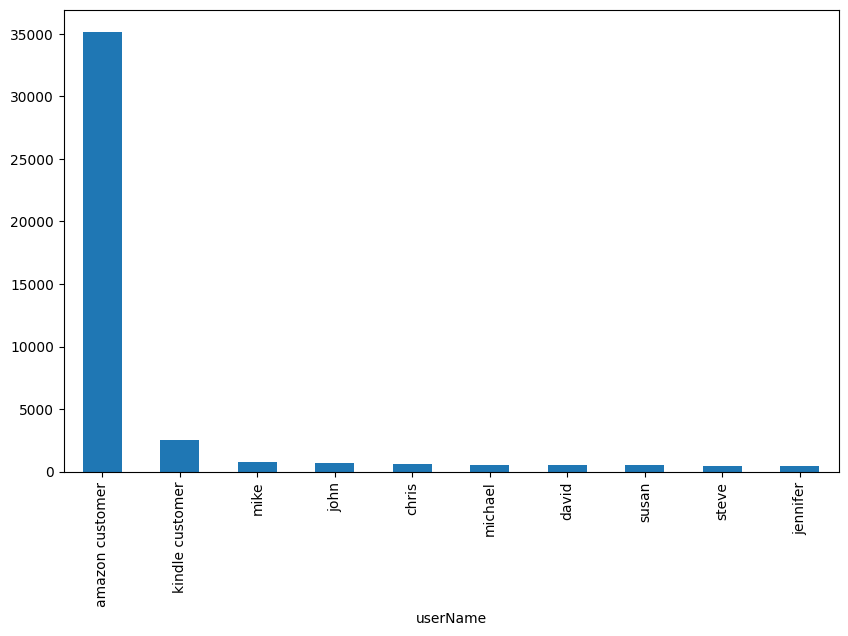

In [66]:
df['userName'].value_counts().head(10).plot(kind='bar', figsize=(10, 6))

As we can there is a huge problem with both Amazon Customer and Kindle Customer

In [67]:
blocked_names = ['amazon customer', 'kindle customer', 'anonymus']

df = df[~df['userName'].str.lower().isin(blocked_names)]

In [68]:
df['userName'].value_counts().head(10)

userName
mike        770
john        660
chris       586
michael     549
david       538
susan       513
steve       437
jennifer    436
lisa        425
linda       423
Name: count, dtype: int64

<Axes: xlabel='category'>

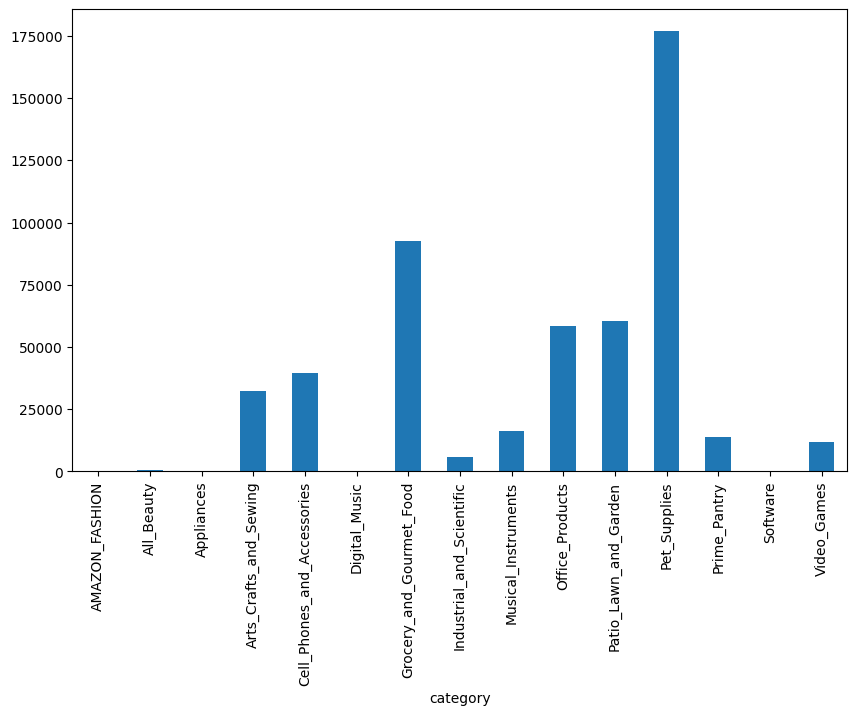

In [69]:
df.groupby('category').size().plot(kind='bar', figsize=(10, 6))

In [70]:
df[['category']].value_counts()

category                   
Pet_Supplies                   176828
Grocery_and_Gourmet_Food        92691
Patio_Lawn_and_Garden           60415
Office_Products                 58634
Cell_Phones_and_Accessories     39642
Arts_Crafts_and_Sewing          32322
Musical_Instruments             16423
Prime_Pantry                    13973
Video_Games                     11736
Industrial_and_Scientific        5816
All_Beauty                        431
Software                          238
Appliances                        209
Digital_Music                      65
AMAZON_FASHION                      6
Name: count, dtype: int64

## TEXT ANALYSIS

In [71]:
import html
import re
import unicodedata

In [72]:
df['reviewText']=df['reviewText'].fillna('')
df['summary']=df['summary'].fillna('')
df['description']=df['description'].fillna('')

In [73]:
RE = {
    "quotes":        re.compile(r'[″"“”]+'),
    "weird_signs":   re.compile(r"[′'‘’;*:~+]+"),
    "whitespace":    re.compile(r"\s+"),
    "html_tags":     re.compile(r"<.*?>"),
    "newlines":      re.compile(r"[\r\n]+"),
    "brackets":      re.compile(r"[()\[\]{}<>（）［］]"),
    "endline":       re.compile(r"[\\]+"),
    "symbols_misc":  re.compile(r"[|*#@^]"),
    "ampersand":     re.compile(r"[&]"),
    "outer_quotes":  re.compile(r'^\s*"+\s*|\s*"+\s*$'),
    "leading_weird": re.compile(r"^(?:#\s*\d+\s*|\d+\s*[xX]\s*)"),
    "multi_dot":     re.compile(r"\.{2,}"),
    "dash_like":     re.compile(r"[‐-‒–—―]+"),
    "multi_dash":    re.compile(r"-{2,}"),
    "slashes":       re.compile(r"[\\/]+"),
    "bang_q":        re.compile(r"([!?])\1+"),
    "sep_space":     re.compile(r"\s*([/\-\\])\s*"),
    "edge_junk":     re.compile(r'^[\s/\-\\]+|[\s/\-\\]+$'),
}


In [ ]:

def clean_item_name(val):
    if pd.isna(val):  
        return ""
    s = str(val).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list) and parsed:
                s = str(parsed[0])  
        except Exception:
            pass
    s   = html.unescape(s)
    s = unicodedata.normalize("NFKC", s)


    s = RE["quotes"].sub('"', s)             
    s = RE["endline"].sub(" ", s)           
    s = RE["outer_quotes"].sub("", s)        
    s = RE["weird_signs"].sub("", s)         
    s = RE["dash_like"].sub("-", s)         
    s = RE["multi_dash"].sub("-", s)         
    s = RE["multi_dot"].sub(".", s)         
    s = RE["ampersand"].sub("and", s)       
    s = RE["symbols_misc"].sub(" ", s)       
    s = RE["slashes"].sub(" ", s)         
    s = RE["bang_q"].sub(".", s)             
    s = RE["sep_space"].sub(r"\1", s)       


    s = RE["html_tags"].sub("", s)          
    s = RE["newlines"].sub(" ", s)          
    s = RE["brackets"].sub("", s)            

   
    s = RE["whitespace"].sub(" ", s).strip()
    s = RE["edge_junk"].sub("", s).strip()
    s = RE["leading_weird"].sub("", s).lstrip()

    return s.lower()

In [75]:
df['itemName']=df['itemName'].apply(clean_item_name)
df['reviewText']=df['reviewText'].apply(clean_item_name)
df['summary']=df['summary'].apply(clean_item_name)
df['description']=df['description'].apply(clean_item_name)

Average review length: 32.13 tokens
Minimum review length: 0 tokens
Maximum review length: 5009 tokens


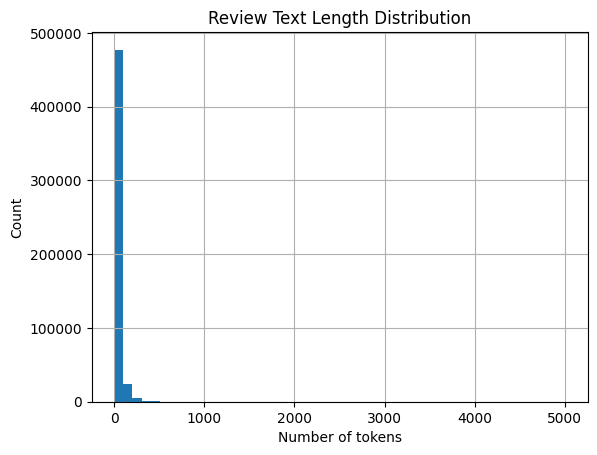

In [76]:
df['review_len'] = df['reviewText'].str.split().apply(len)

print(f"Average review length: {df['review_len'].mean():.2f} tokens")
print( f"Minimum review length: {df['review_len'].min()} tokens")
print(f"Maximum review length: {df['review_len'].max()} tokens")

plt.figure()
df['review_len'].hist(bins=50)
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("Review Text Length Distribution")
plt.show()

<Axes: xlabel='rating'>

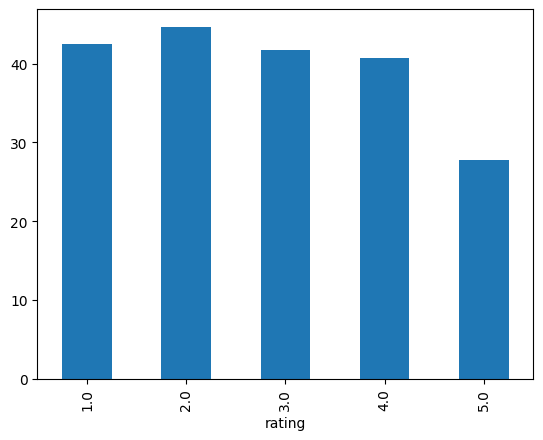

In [77]:
df.groupby('rating')['review_len'].mean().plot(kind='bar')

In [78]:
vectorizer = CountVectorizer(ngram_range=(2,3), max_df=0.95, stop_words='english',min_df=2,
                            analyzer = 'word')
X = vectorizer.fit_transform(df['reviewText'])
bigrams = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
print(sorted(bigrams, key=lambda x: -x[1])[:20])

[('works great', 12240), ('great product', 10009), ('good quality', 6720), ('great price', 6252), ('dog loves', 5773), ('good product', 5448), ('highly recommend', 5315), ('dogs love', 5075), ('good price', 4849), ('easy use', 4349), ('really like', 3966), ('cats love', 3642), ('long time', 3601), ('dont know', 3485), ('year old', 3112), ('great quality', 3109), ('high quality', 2960), ('make sure', 2897), ('ive used', 2830), ('really good', 2733)]


As we can see  most of reviews are positive

In [79]:

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 3),
                        analyzer='word',max_df=0.95, min_df=2)
X_tfidf = tfidf.fit_transform(df['reviewText'])


In [80]:
features = tfidf.get_feature_names_out()
sums = X_tfidf.sum(axis=0)
term_weights = [(features[i], sums[0, i]) for i in range(X_tfidf.shape[1])]


sorted_terms = sorted(term_weights, key=lambda x: x[1], reverse=True)
print(sorted_terms[:20])


[('great product', 3762.8203978541314), ('works great', 3700.217906698497), ('good product', 2461.706544816748), ('dog loves', 1754.5812800415968), ('good quality', 1647.90106639072), ('dogs love', 1644.753141321386), ('great price', 1600.0333308363467), ('good price', 1344.0946706674965), ('cats love', 1184.1872524847822), ('great quality', 851.707123873379), ('easy use', 837.3436121533715), ('work great', 734.6657243031652), ('cat loves', 696.9651987098598), ('excellent product', 693.9808459245281), ('does job', 687.878234167698), ('worked great', 655.780192985426), ('highly recommend', 637.5700364776108), ('great value', 620.4777979808221), ('works good', 608.3051337787363), ('good stuff', 583.7251890843843)]


In [81]:

# df['sentiment'] = df['reviewText'].apply(lambda t: TextBlob(t).sentiment.polarity)
# df['sentiment'].hist(bins=50)
# plt.title("Review Polarity Distribution")
# plt.show()

Average review length: 12.50 tokens
Minimum review length: 1 tokens
Maximum review length: 107 tokens


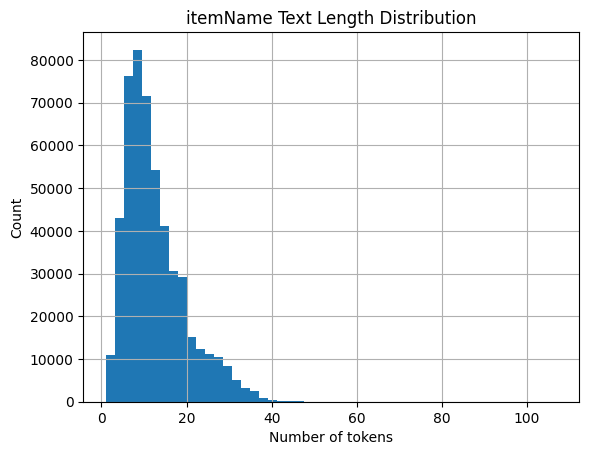

In [82]:
df['itemName_len'] = df['itemName'].str.split().apply(len)

print(f"Average review length: {df['itemName_len'].mean():.2f} tokens")
print( f"Minimum review length: {df['itemName_len'].min()} tokens")
print(f"Maximum review length: {df['itemName_len'].max()} tokens")

plt.figure()
df['itemName_len'].hist(bins=50)
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("itemName Text Length Distribution")
plt.show()

Average review length: 1.60 tokens
Minimum review length: 1 tokens
Maximum review length: 73 tokens


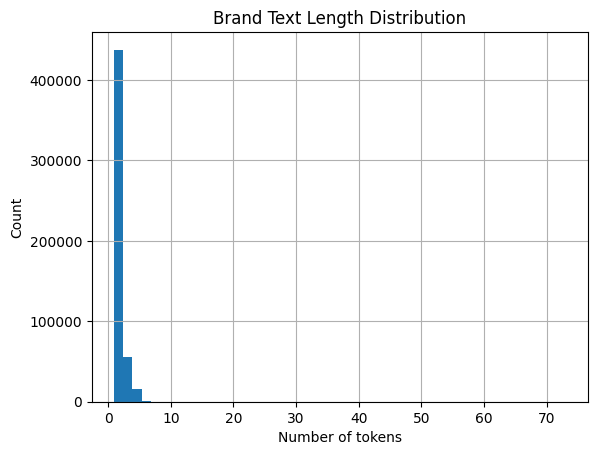

In [83]:
df['brand_len'] = df['brand'].str.split().apply(len)

print(f"Average review length: {df['brand_len'].mean():.2f} tokens")
print( f"Minimum review length: {df['brand_len'].min()} tokens")
print(f"Maximum review length: {df['brand_len'].max()} tokens")

plt.figure()
df['brand_len'].hist(bins=50)
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("Brand Text Length Distribution")
plt.show()

Average review length: 72.62 tokens
Minimum review length: 0 tokens
Maximum review length: 1239 tokens


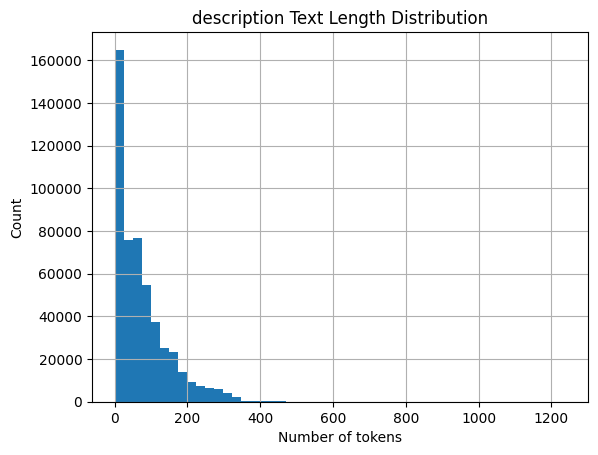

In [84]:
df['description_len'] = df['description'].str.split().apply(len)

print(f"Average review length: {df['description_len'].mean():.2f} tokens")
print( f"Minimum review length: {df['description_len'].min()} tokens")
print(f"Maximum review length: {df['description_len'].max()} tokens")

plt.figure()
df['description_len'].hist(bins=50)
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.title("description Text Length Distribution")
plt.show()

In [85]:
def fake_description(row):
    brand = row.get("brand", "").strip()
    item  = row.get("itemName", "").strip()
    category= row.get("category", "").strip()
    if brand and item and category:
        return f"This is a {item} from {brand} in the category of {category}."
    elif brand and item:
        return f"This is a {item} from {brand}."
    elif item and category:
        return f"This is a {item} in the category of {category}."
    elif brand and category:
        return f"This is a product from {brand} in the category of {category}."
    elif item:
        return f"This is a {item}."
    elif brand:
        return f"This is a product from {brand}."
    elif category:
        return f"This is a product in the category of {category}."
    else:
        return "No description available."

In [86]:
df["description"] = df.apply(
    lambda r: r["description"] if r['description_len']!=0 and r['description']!='[]' else fake_description(r),
    axis=1
)

In [87]:
df['description_len'] = df['description'].str.split().apply(len)
df['description_len'].min()

1

In [88]:
def fake_review(row):
    return f"This is a review for {row['itemName']} by {row['brand']}. The user {row['userName']} rated it {row['rating']} stars."
df["reviewText"] = df.apply(
    lambda r: r["reviewText"] if r['review_len']!=0 else fake_review(r),
    axis=1
)

In [89]:
df['review_len'] = df['reviewText'].str.split().apply(len)
df['review_len'].min()

1

Saving in json

In [90]:
df.rename(columns={'itemName':'item_name',
                   'userName':'user_name',
                   'reviewText':'review_text'},inplace=True)

In [91]:
df['user_id'], user_unique = pd.factorize(df['user_name'])
df['item_id'], item_unique = pd.factorize(df['item_name'])

In [92]:
df_prod=df[['item_id','item_name','brand','price','category','description','review_text','rating']]

In [93]:
df_prod=(df_prod.groupby(['item_id','item_name','brand','category','description','price']).agg(
          number_of_ratings=("rating", "count"),
          avg_rating=("rating", "mean"),
          reviews=('review_text',lambda s: [t.strip() for t in s.dropna().astype(str) ])
      )
      .reset_index())
df_prod

,item_id,item_name,brand,category,description,price,number_of_ratings,avg_rating,reviews
0,0,"prince of peace organic tea, oolong, 100 tea bags",prince of peace,Grocery_and_Gourmet_Food,"prince of peace enterprises, inc., founded in ...",6.40,87,4.586207,"[perfect for kombucha, perfect for kombucha, g..."
1,1,"pet champion adjustable no-pull harness, colla...",pet champion,Pet_Supplies,the pet champion large extra large 22-36 inch ...,7.99,11,3.909091,[finally a harness that fits my puppy. i reall...
2,2,koh-i-noor progresso woodless colored 24-penci...,koh-i-noor,Arts_Crafts_and_Sewing,koh-i-noor progresso woodless colored 24-penci...,14.18,2,5.000000,[i love them. i bought them at micheals our of...
3,3,"parker urban premium ebony metal chiseled, bal...",parker,Office_Products,stunning craftsmanship based on a classic styl...,10.99,3,5.000000,"[i love this pen! i love the shape of it, the ..."
4,4,merrick whole earth farms adult recipe dry dog...,merrick,Pet_Supplies,merrick whole earth farms is a nutritious dog ...,13.92,6,4.333333,[we accidentally purchased this instead of our...
...,...,...,...,...,...,...,...,...,...
105712,105011,3d pla 1.75mm blue plastic 3d printer printing...,labelpros,Industrial_and_Scientific,This is a 3d pla 1.75mm blue plastic 3d printe...,18.96,1,5.000000,[this is a very nice shade of blue. i really l...
105713,105012,tangkula patio furniture outdoor lawn backyard...,tangkula,Patio_Lawn_and_Garden,descriptionthis is our new tangkula outdoor pa...,22.41,1,5.000000,[i am rating this product amongst daybeds. it ...
105714,105013,galaxy wireless compatible for zte zmax pro ca...,galaxy wireless,Cell_Phones_and_Accessories,description this protective case offers the ul...,6.99,1,5.000000,[nice case. too bad the phones suck.]
105715,105014,"icefang tactical k9 working dog collar,metal b...",icefang,Pet_Supplies,This is a icefang tactical k9 working dog coll...,8.99,1,4.000000,[i love the quality and construction 5 stars o...


In [95]:
cols = ['item_id',"item_name", "brand","category", "price", "reviews",'avg_rating','number_of_ratings','description']
records = df_prod[cols].drop_duplicates(['item_id']).to_dict(orient="records")

with open("../Data/Cleaned/ProductsRAG.json", "w") as f:
    json.dump(records, f, indent=2)

In [99]:
df[['user_id','user_name']].drop_duplicates().to_csv('../Data/Cleaned/users.csv',index=False,columns=('user_id','user_name'))


In [96]:
df[['item_id','item_name','category','brand','description','price']].drop_duplicates(subset=['item_id']).to_csv('../Data/Cleaned/items.csv',index=False,columns=('item_id','item_name','category','brand','description','price'))

In [97]:
df['purchase_id']=np.arange(0,df.shape[0])
df[['purchase_id','user_id','item_id','rating','review_text','verified']].to_csv('../Data/Cleaned/interactions.csv',index=False,columns=('purchase_id','user_id','item_id','rating','review_text','verified'))